In [2]:
from catalogue import *
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

from keras.metrics import categorical_accuracy


Using TensorFlow backend.


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

RuntimeError: module compiled against API version 0xc but this version of numpy is 0xb

In [3]:
inputs, outputs, error, df_original = load_data()
print "Number of stars:", inputs.shape[0]
print "Shape of inputs, outputs, and error from loading data..."
print inputs.shape, outputs.shape, error.shape

/opt/conda/lib/python2.7/site-packages/pandas/core/frame.py:5085: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[col] = expressions.where(mask, this, that)


Number of stars: 142750
Shape of inputs, outputs, and error from loading data...
(142750, 9) (142750, 3) (142750, 3)


In [4]:
inputs['u-g'] = inputs['u'].subtract(inputs['g'])
inputs['u-i'] = inputs['u'].subtract(inputs['i'])
inputs['g-r'] = inputs['g'].subtract(inputs['r'])
inputs['g-z'] = inputs['g'].subtract(inputs['z'])

m = 0.42 # u - g
b = 0.3 # g - r

# Apply a color cut to remove the contaminent stars (i.e. that are not giants or dwarfs)
colour_cut_a = (m*inputs['u-g'] - b > inputs['g-r'])
colour_cut_b = (m*inputs['u-g'] - b <= inputs['g-r'])


a_star=inputs[colour_cut_a]
outputs=outputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
error=error[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 
inputs=inputs[colour_cut_b] # 0.42*(u-g)-0.3 <= (g-r) 

print "Number of stars after colour cut:", inputs.shape[0]

Number of stars after colour cut: 132153


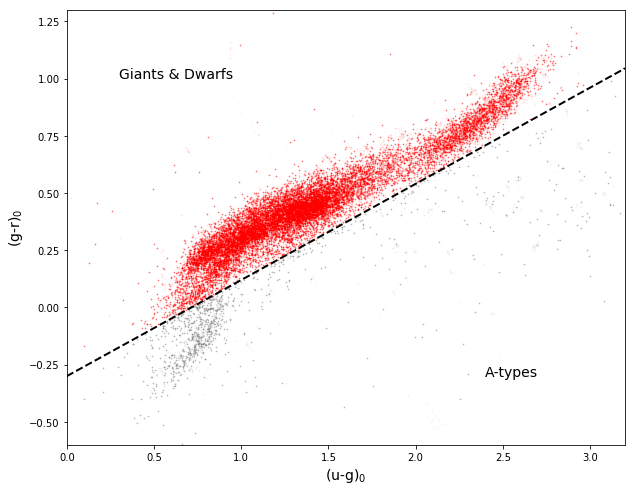

In [5]:
plt.figure(figsize=(10,8))
plt.scatter(inputs['u-g'], inputs['g-r'], s=0.5, c="red",alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
plt.scatter(a_star['u-g'], a_star['g-r'], s=0.5, c='grey',alpha=0.05,edgecolors=None, cmap=plt.cm.RdBu,rasterized=True)
line=np.arange(0.0,3.5,0.002)
plt.plot(line,0.42*line-0.3,"k--",lw=2)
plt.xlabel('(u-g)$_0$',fontsize=14)
plt.ylabel('(g-r)$_0$',fontsize=14)
plt.xlim(0.0,3.2)
plt.ylim(-0.6,1.3)
plt.ylabel('(g-r)$_0$')
plt.annotate(r"Giants & Dwarfs", xy=(0.3,1.0), xytext=(0.3, 1.0), color='black',size=14)
plt.annotate(r"A-types", xy=(2.4,-0.3), xytext=(2.4, -0.3), color='black',size=14)

plt.rcParams['pdf.fonttype']=42
plt.savefig("color_color_ML.pdf", format='pdf')
plt.show()

In [6]:
# Apply the color cuts for machine learning 
ui_thres = 1.3
gz_thres = 0.05

# Select only the lowest error in logg
logg_error_thres = 0.16

ml_cut =  (inputs['u-i'] >= ui_thres) & (inputs['u-i'] <= 2.6) & (inputs['g-z'] >= gz_thres)

input_forML2 = inputs[ml_cut]
output_forML2 = outputs[ml_cut]
error_forML2 = error[ml_cut]

logg_cut = (error_forML2['dlogg'] <= logg_error_thres)

input_finalML2 = input_forML2[logg_cut].reset_index(drop=True)
output_finalML2 = output_forML2[logg_cut].reset_index(drop=True)
error_finalML2 = error_forML2[logg_cut].reset_index(drop=True)

# For binary classification, we need to set the threshold for which
# logg we decide is a dwarf or a giant
output_finalML2['logg_binary'] = np.where(output_finalML2['logg'] > 3.5, 'dwarf', 'giant')

def classify_logg(val):
    if val >= 4.:
        return 2
    elif val < 4. and val > 3.:
        return 1
    else:
        return 0
    
output_finalML2['logg_trinary'] = output_finalML2.apply(lambda x: classify_logg(x['logg']), axis=1)

print "Number of stars after machine learning cuts in u-i, and g-z:", input_finalML2.shape[0]

Number of stars after machine learning cuts in u-i, and g-z: 76721


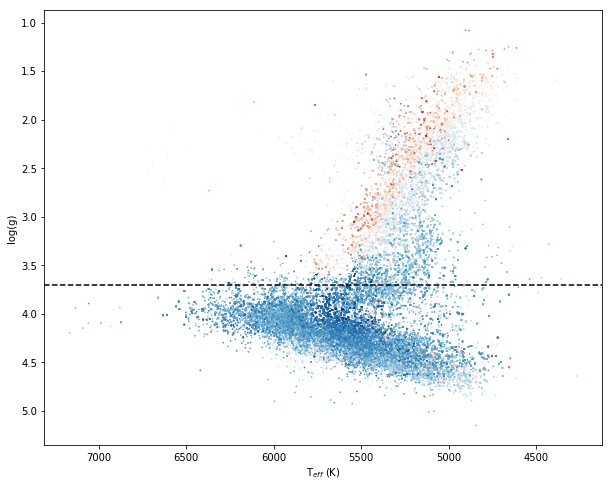

In [7]:
# Plot the position of the stars in a Teff-logg diagram
plt.figure(figsize=(10,8))
plt.scatter(output_finalML2['Teff'].values, output_finalML2['logg'].values, s=0.5,rasterized=True, c=output_finalML2['feh'],alpha=0.8,edgecolors=None, cmap=plt.cm.RdBu)
plt.axhline(y=3.7, color='k', linestyle='--')
plt.xlabel('T$_{eff}$ (K)')
plt.ylabel('log(g)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

In [8]:
###########
# Need to keep all these transformation => you should make the transformation subroutine
###########

colour_mean_logg = [input_finalML2[key].describe()['mean'] for key in input_finalML2]
colour_std_logg = [input_finalML2[key].describe()['std'] for key in input_finalML2]

mean_logg = output_finalML2['logg'].describe()['mean']
std_logg = output_finalML2['logg'].describe()['std']

error_logg_min=error_finalML2['dlogg'].describe()['min']
error_logg_max=error_finalML2['dlogg'].describe()['max']

stats_array = (input_finalML2, output_finalML2, error_finalML2)

# write final input and output dataframes to pickle file to load externally
with open('./stats_summary.pickle', 'r+') as f:
    pickle.dump(stats_array, f)

input_finalML2.sample(frac=1) # randomly shuffle order of pandas dataframe

# Normalize the data using custom normalize function
# default is using mean and stdev. Errors use min_max method
inputf = normalize(input_finalML2)
outputf = normalize(output_finalML2)
errorf = normalize(error_finalML2, 'min_max')

inputf_train = inputf.sample(frac=0.8, random_state=99)
inputf_test = inputf.loc[~inputf.index.isin(inputf_train.index), :]

outputf_train = outputf.sample(frac=0.8, random_state=99)
outputf_test = outputf.loc[~outputf.index.isin(outputf_train.index), :]

errorf_train = errorf.sample(frac=0.8, random_state=99)
errorf_test = outputf.loc[~errorf.index.isin(errorf_train.index), :]

train_frac = inputf_train.shape[0]/float(inputf.shape[0])
test_frac = inputf_test.shape[0]/float(inputf.shape[0])


print "Fraction of data for training:", train_frac
print "Fraction of data for testing:", test_frac
print "Check total is always 1.0:", train_frac+test_frac

Fraction of data for training: 0.800002606848
Fraction of data for testing: 0.199997393152
Check total is always 1.0: 1.0


In [9]:
x_train = inputf_train
y_train = outputf_train['logg_binary']

x_test = inputf_test
y_test = outputf_test['logg_binary']

x_error = errorf_test
y_error = errorf_train['dlogg']

In [10]:
# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(x_train, y_train)
preds = gnb.predict(x_test)
# Evaluate accuracy
print "Accuracy", accuracy_score(y_test, preds)

Accuracy 0.786366006257


In [11]:
seed = 7
np.random.seed(seed)

X = inputf.values.astype(float)
Y = outputf['logg_trinary'].values
# loading the iris dataset
print X.shape, Y.shape
 
# X -> features, y -> label
y = Y
print Y

(76721, 13) (76721,)
[2 2 1 ..., 1 0 2]


In [12]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(outputf['logg_binary'])
encoded_Y = encoder.transform(outputf['logg_binary'])

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=13, kernel_initializer='normal', activation='relu')) #v input_dim=13,
    model.add(Dense(5096, kernel_initializer='normal', activation='relu'))
    #model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(256, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

new_model = False
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

if new_model:
    # evaluate model with standardized dataset
    print "Baseline creation..."
    estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=1000, verbose=1)
    y_pred = cross_val_predict(estimator, X, encoded_Y, cv=kfold, n_jobs = 2)
    y_val = (y_pred, encoded_Y)
    pickle.dump(y_val, open( "./binary_class_pred.pickle", "wb" ) )

else:
    y_val = pickle.load(open( "./binary_class_pred.pickle", "rb" ))
    
y_pred = y_val[0]
encoded_Y = y_val[1]

Baseline creation...
mark!
mark!
Epoch 1/100
Epoch 1/100
38360/38360 [==============================] - 8s 201us/step - loss: 0.4807 - acc: 0.7943
Epoch 2/100
38361/38361 [==============================] - 8s 219us/step - loss: 0.4783 - acc: 0.7949
Epoch 2/100
38360/38360 [==============================] - 6s 154us/step - loss: 0.3495 - acc: 0.8574
Epoch 3/100
38361/38361 [==============================] - 6s 147us/step - loss: 0.3551 - acc: 0.8540
Epoch 3/100
38361/38361 [==============================] - 6s 167us/step - loss: 0.3220 - acc: 0.8681
Epoch 4/100
38360/38360 [==============================] - 7s 183us/step - loss: 0.3182 - acc: 0.8730
Epoch 4/100
38361/38361 [==============================] - 5s 138us/step - loss: 0.3070 - acc: 0.8718
Epoch 5/100
38360/38360 [==============================] - 6s 161us/step - loss: 0.3039 - acc: 0.8767
Epoch 5/100
38360/38360 [==============================] - 6s 156us/step - loss: 0.2986 - acc: 0.8769
Epoch 6/100
38361/38361 [============

38361/38361 [==============================] - 6s 150us/step - loss: 0.1768 - acc: 0.9255
Epoch 39/100
38360/38360 [==============================] - 5s 138us/step - loss: 0.1824 - acc: 0.9234
Epoch 39/100
38361/38361 [==============================] - 6s 157us/step - loss: 0.1689 - acc: 0.9302
Epoch 40/100
38361/38361 [==============================] - 5s 136us/step - loss: 0.1673 - acc: 0.9318
Epoch 41/100
38360/38360 [==============================] - 6s 169us/step - loss: 0.1727 - acc: 0.9288
Epoch 41/100
38361/38361 [==============================] - 6s 155us/step - loss: 0.1652 - acc: 0.9320
Epoch 42/100
38360/38360 [==============================] - 6s 156us/step - loss: 0.1739 - acc: 0.9286
Epoch 42/100
38361/38361 [==============================] - 5s 137us/step - loss: 0.1573 - acc: 0.9363
Epoch 43/100
38361/38361 [==============================] - 7s 175us/step - loss: 0.1597 - acc: 0.9338
Epoch 44/100
38360/38360 [==============================] - 5s 138us/step - loss: 0.17

38360/38360 [==============================] - 7s 179us/step - loss: 0.0706 - acc: 0.9732
Epoch 75/100
38361/38361 [==============================] - 6s 164us/step - loss: 0.0778 - acc: 0.9700
Epoch 74/100
38360/38360 [==============================] - 6s 162us/step - loss: 0.0766 - acc: 0.9695
Epoch 76/100
38361/38361 [==============================] - 7s 177us/step - loss: 0.0734 - acc: 0.9717
Epoch 75/100
38360/38360 [==============================] - 6s 153us/step - loss: 0.0754 - acc: 0.9712
Epoch 77/100
38361/38361 [==============================] - 7s 170us/step - loss: 0.0842 - acc: 0.9673
Epoch 76/100
38360/38360 [==============================] - 6s 156us/step - loss: 0.0778 - acc: 0.9685
Epoch 78/100
38360/38360 [==============================] - 6s 163us/step - loss: 0.0744 - acc: 0.9708
Epoch 79/100
38361/38361 [==============================] - 5s 138us/step - loss: 0.0662 - acc: 0.9763
Epoch 78/100
38360/38360 [==============================] - 6s 153us/step - loss: 0.07

In [13]:
print y_pred

[[0]
 [0]
 [0]
 ..., 
 [0]
 [1]
 [0]]


In [18]:
# TO DO:
# Demonstrate, using 1 fold and 1 split of the data that
# we do not overfit up to around 100 epochs.
# Then plot the ROC for each fold!

conf_mat = confusion_matrix(y,y_pred)
y_true = pd.Series(outputf['logg_binary'])
y_predicted = encoder.inverse_transform(y_pred[:,0])
y_prd = pd.Series(y_predicted)

display(pd.crosstab(y_true, y_prd, rownames=['True'], colnames=['Predicted'], margins=True))
cm = confusion_matrix(y_true, y_prd)

tp0, fn, fp, tp1 = map(float, cm.ravel())

tp = tp0+tp1
precision = tp/(tp+fp)
accuracy = (tp0+tp1)/ (tp0+tp1+fn+fp)
recall = tp/(tp+fn)
recall_1 = tp0/(tp0+fn)
recall_2 = tp1/(tp1+fn)
F1 = 2*(recall * precision) / (recall + precision)
completeness = tp0/(tp0+fp)
purity = tp1/(tp1+fp)
print "Accuracy:", accuracy
print "Precision:", precision
print "Recall:",recall, recall_1, recall_2
print "F1:", F1
print "Completeness:", completeness
print "Purity:", purity

Predicted,dwarf,giant,All
True,,,
dwarf,60944,774,61718
giant,1413,13590,15003
All,62357,14364,76721


Accuracy: 0.97149411504
Precision: 0.981394920142
Recall: 0.989722207468 0.98745908811 0.946115288221
F1: 0.985540973852
Completeness: 0.977340154273
Purity: 0.905818836233


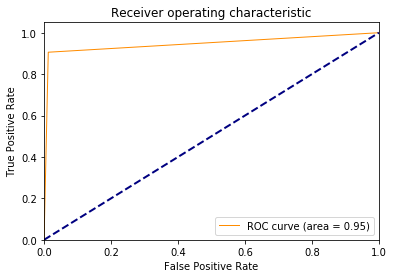

"\nhistory = y_pred#estimator.fit(X, Y, validation_split=0.33, epochs=100, batch_size=1000, verbose=1)          \nprint history.history.keys() \n# summarize history for accuracy\nplt.plot(history.history['acc'])\nplt.plot(history.history['val_acc'])\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n# summarize history for loss\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()"

In [15]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(encoded_Y, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

'''
history = y_pred#estimator.fit(X, Y, validation_split=0.33, epochs=100, batch_size=1000, verbose=1)          
print history.history.keys() 
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()'''

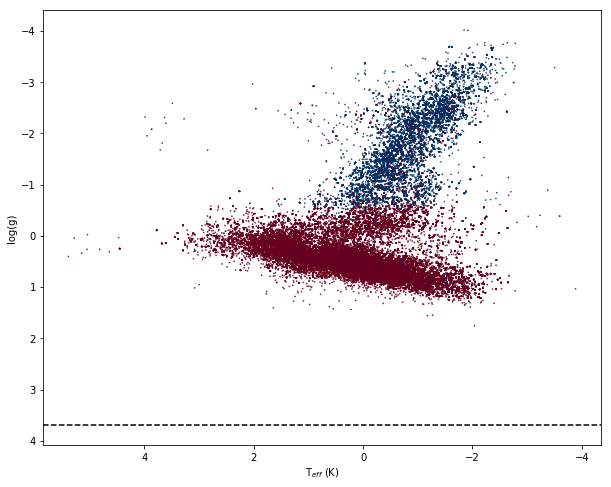

In [19]:
outputf['class_pred'] = y_pred
# Plot the position of the stars in a Teff-logg diagram
plt.figure(figsize=(10,8))
plt.scatter(outputf['Teff'].values, outputf['logg'].values, s=0.5,rasterized=True, c=outputf['class_pred'],alpha=0.8,edgecolors=None, cmap=plt.cm.RdBu)
plt.axhline(y=3.7, color='k', linestyle='--')
plt.xlabel('T$_{eff}$ (K)')
plt.ylabel('log(g)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

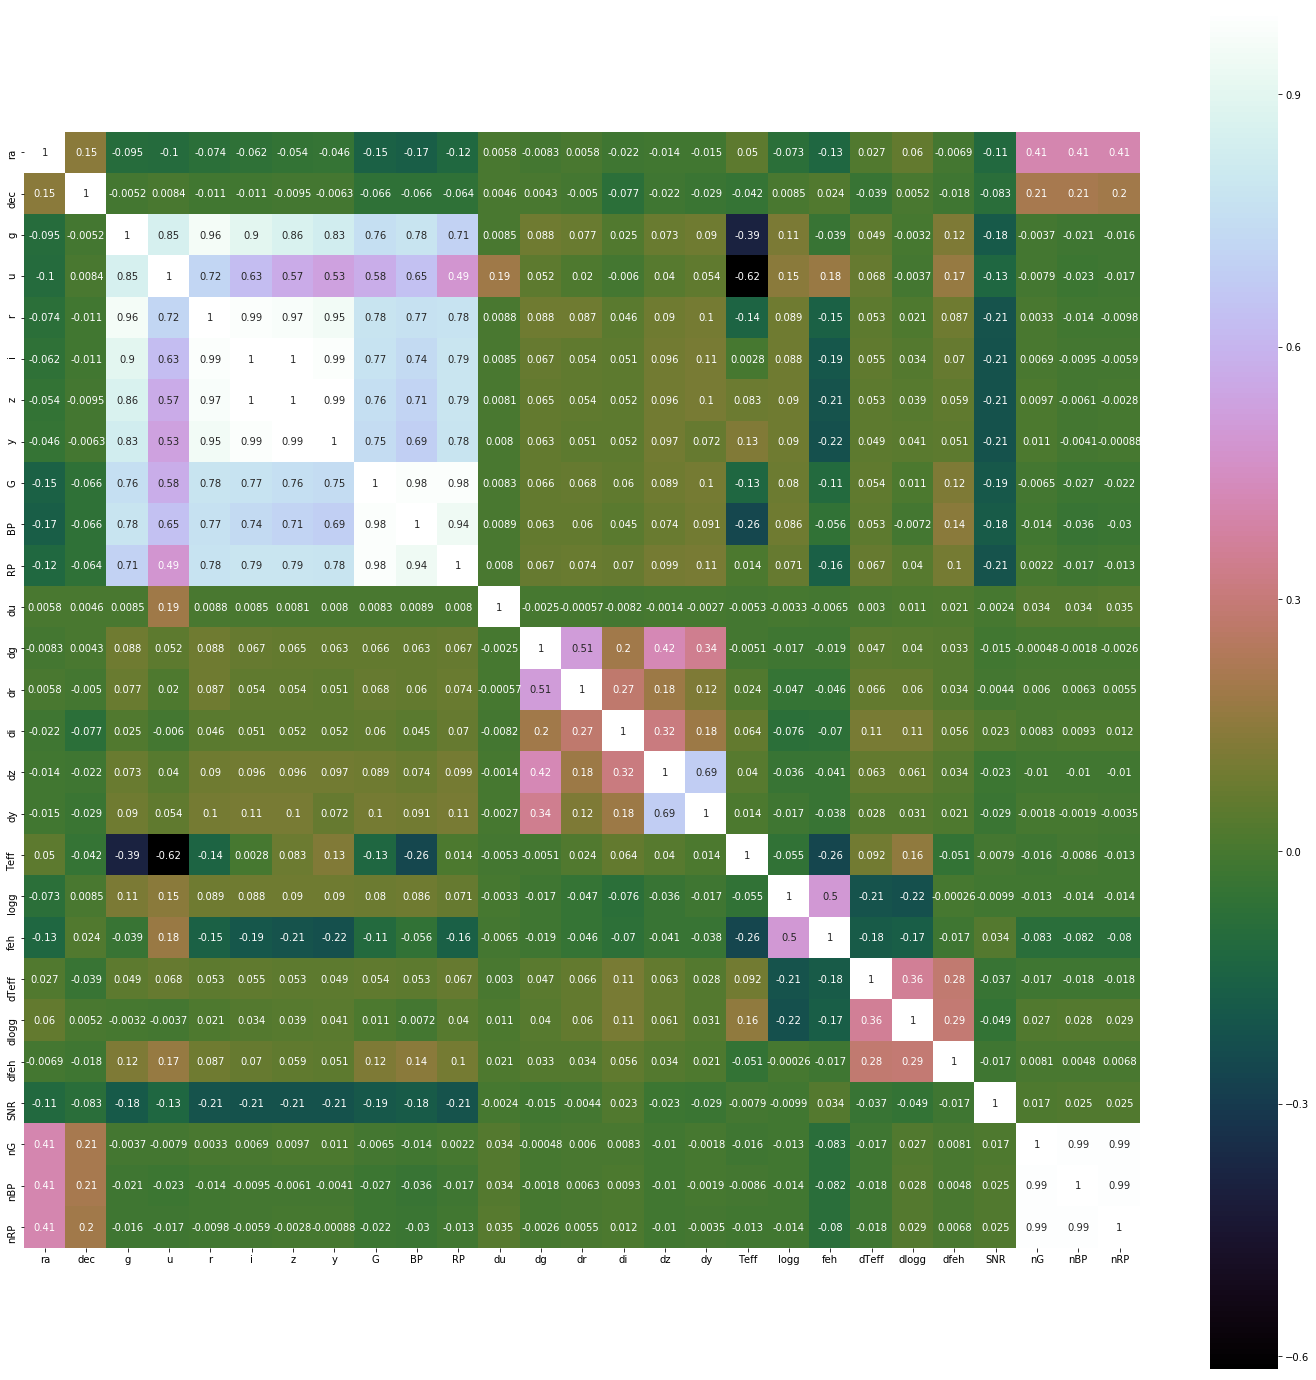

In [16]:
import seaborn as sns  

correlation = df_original.corr()  
plt.figure(figsize=(25, 25))  
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')
plt.savefig('correlation.pdf')

In [17]:
#history = model.fit(X, Y, validation_split=0.33, epochs=500, batch_size=1000, verbose=1)          
print history.history.keys() 
plt.figure(figsize=(10, 8))
# summarize history for accuracy
plt.semilogy(history.history['acc'])
plt.semilogy(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(10, 8))

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
# importing necessary libraries
 
# loading the iris dataset
print X.shape, Y.shape
 
# X -> features, y -> label
y = Y
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
 
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 11).fit(X_train, y_train)
 
# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print accuracy

print np.sqrt(len(Y))
 
# creating a confusion matrix
knn_predictions = knn.predict(X_test) 
cm = confusion_matrix(y_test, knn_predictions)

y_true = pd.Series(y_test)
y_pred = pd.Series(knn_predictions)

display(pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

#2*TP /(2*TP + FP + FN)
print "F1, 0", 2.*cm[0,0]/(np.sum(cm[0,:])+np.sum(cm[:,0]))
print "F1, 1", 2.*cm[1,1]/(np.sum(cm[1,:])+np.sum(cm[:,1]))
print "F1, 2", 2.*cm[2,2]/(np.sum(cm[2,:])+np.sum(cm[:,2])

### Make colour colour plots to find out what the overfitting looks like at low k values
### TNSE


# 